In [1]:
!pip install einops
!pip install git+https://github.com/huggingface/transformers

  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.9 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-88e38id1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-88e38id1
  Resolved https://github.com/huggingface/transformers to commit d93ef7d7512e79612606f29e6ae308920f0a86cd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.37.0.dev0-py3-none-any.whl size=8341223 sha256=c231c506febb7ea6236b6a7dcc3ff11462334cd15e1859130ec62aab1d651bdc
  Stored in directory: /tmp/pip-ephem-wheel-cache-cvgoigkd/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151

In [62]:
import random
import torch
import copy

import pandas as pd

from tqdm.notebook import tqdm

from gensim.test.utils import datapath

from scipy.stats import pearsonr, spearmanr

from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig

import matplotlib.pyplot as plt

# Import Models

In [3]:
device = "cuda"
torch.set_default_device(device)

In [4]:
phi = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
tokenizer_phi = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
config_phi = AutoConfig.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)

phi = phi.eval()
phi.zero_grad()

config.json:   0%|          | 0.00/869 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-1_5:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-1_5:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [5]:
gpt = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
config_gpt = AutoConfig.from_pretrained("gpt2", trust_remote_code=True)

gpt.eval()
gpt.zero_grad()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
phi_emb = phi.get_input_embeddings()
gpt_emb = gpt.get_input_embeddings()

# Define Helper Functions

In [7]:
def multiencode(tok, words, return_tensors="pt"):
    if (isinstance(words, list) or isinstance(words, tuple)) and not isinstance(words, str):
        return torch.cat([tok.encode(word, return_tensors="pt") for word in words], dim=-1)
    else:
        return tok.encode(words, return_tensors="pt")
    
def avgencode(emb, word, tok=None, avg=True):
    source = word
    # If input is a string tokenize it
    if (isinstance(word, str) or isinstance(word[0], str)) and tok is not None:
        word = emb(multiencode(tok, word))
    # Calculate average if avg flag is true and if it is needed
    if word.shape[1] != 1 and avg:
        word = torch.unsqueeze(torch.mean(word, dim=1), dim=1)
    elif word.shape[1] != 1 and not avg:
        raise Exception(f"{source} is not a single token: {word}")
    return word

In [8]:
def calc_distance(emb, word1, word2, tok=None, avg=True, dist="cosine", multi=False):
    # Encode and average (if multi is True, word1 represents the embedding matrix)
    if not multi:
        word1 = avgencode(emb, word1, tok, avg=avg)
    word2 = avgencode(emb, word2, tok, avg=avg)
    # Compute distances
    if dist == "L2":
        distances = torch.norm(word1 - word2, dim=2)
    elif dist == "cosine":
        cs = torch.nn.CosineSimilarity(dim=2)
        distances = 1 - cs(word1, word2)
    else:
        raise Exception("Unknown distance")
    return distances

def get_closest_emb(emb, word, k=1, decode=True, tok=None, avg=True, dist="cosine"):
    # Compute distances
    distances = calc_distance(emb, emb.weight.data, word, tok=tok, avg=avg, dist=dist, multi=True)
    # Compute top k smalles indices
    topk = torch.squeeze(torch.topk(distances, k=k, largest=False).indices)
    # If one element, unsqueeze it
    if k == 1:
        topk = torch.unsqueeze(topk, dim=0)
    # Decode closest k
    if decode and tok is not None:
        topk = [tok.decode(c) for c in topk.tolist()]
    return topk

def emb_arithmetic(emb, tok, words, k=1, avg=True, dist="cosine"):
    # Encode and average
    words_emb = [avgencode(emb, word, tok, avg=avg) for word in words]
    # Compute embeddings
    w1 = words_emb[0]
    w2 = words_emb[1]
    w3 = words_emb[2]
    # Do embedding arithmetic
    if dist == "L2":
        w = torch.nn.functional.normalize(w1 - w2 + w3, dim=0)
    else:
        w = w1 - w2 + w3
    # Get closest k
    closest = get_closest_emb(emb, w, k=k, decode=True, tok=tok, dist=dist)
    return (w, closest)

def print_results(res):
     for i, r in enumerate(res):
        print(f"{i+1}) {r}")

In [59]:
def batch_emb_arithmetic(emb, tok, queries, k=5, avg=True, dist="cosine", out=True):
    ret = []
    for q in queries:
        if out:
            print("##########################")
            # Print title
            title_q = q
            if not isinstance(q[0], str):
                title_q = [qq[0] for qq in q]
            print(f"{title_q[0]} - {title_q[1]} + {title_q[2]} =")
        # Compute and print results
        res = emb_arithmetic(emb, tok, q, k=k, avg=avg, dist=dist)
        if out:
            print_results(res[1])
        ret.append(res)
    return ret

def evaluate_batch(results, solutions, out=True, score="rankscore", k=None):
    
    def get_rank(r, s, out=0):
        try:
            return r.index(s)
        except ValueError:
            return out
    
    n = len(results[0][1])
    ev = []
    for res, sol in zip(list(map(lambda x: x[1], results)), solutions):
        # Get rank of each solution for each result outputs
        ranks = [get_rank(res, s, out=n) for s in sol]
        # Append best rank to final evaluation list
        ev.append(min(ranks))
    # Return score
    if score == "rankscore":
        score = 1 - ( sum(ev) / (n * len(solutions)) )
    elif score == "topk":
        if not k:
            raise Exception(f"Invalid k for topk")
        score = len([i for i in ev if i < k]) / len(ev)
    else:
        raise Exception(f"Unknown Score")
    if out:
        print(f"{ev} -> {score}")
    return score

# Define Test Cases

### Capital Arithmetic

In [14]:
capital_arithmetic = [
    ["Rome Rome", "Italy Italy", "France France"],
    ["Rome Rome", "Italy Italy", "Australia Australia"],
    ["Paris Paris", "France France", "Italy Italy"],
    ["Paris Paris", "France France", "Australia Australia"],
    ["Canberra Canberra", "Australia Australia", "Italy Italy"],
    ["Canberra Canberra", "Australia Australia", "France France"],
]
capital_single = [
    [" Rome", " Italy", " France"],
    [" Rome", " Italy", " Australia"],
    [" Paris", " France", " Italy"],
    [" Paris", " France", " Australia"],
    [" Canberra", " Australia", " Italy"],
    [" Canberra", " Australia", " France"],
]
capital_arithmetic_lowercase = [
    ["rome rome", "italy italy", "france france"],
    ["rome rome", "italy italy", "australia australia"],
    ["paris paris", "france france", "italy italy"],
    ["paris paris", "france france", "australia australia"],
    ["canberra canberra", "australia australia", "italy italy"],
    ["canberra canberra", "australia australia", "france france"],
]
capital_sol = [
    ["Paris", " Paris", "paris", " paris"],
    ["Canberra", " Canberra", "canberra", " canberra"],
    ["Rome", " Rome", "rome", " rome"],
    ["Canberra", " Canberra", "canberra", " canberra"],
    ["Rome", " Rome", "rome", " rome"],
    ["Paris", " Paris", "paris", " paris"],
]

### Sex Arithmetic

In [15]:
sex_arithmetic = [
    ["King King", "Man Man", "Woman Woman"],
    ["Queen Queen", "Woman Woman", "Man Man"],
    ["Prince Prince", "Man Man", "Woman Woman"],
    ["Princess Princess", "Woman Woman", "Man Man"],
    ["Priest Priest", "Man Man", "Woman Woman"],
    ["Nun Nun", "Woman Woman", "Man Man"],
]
sex_arithmetic_lowercase_single = [
    [" king", " man", " woman"],
    [" queen", " woman", " man"],
    [" prince", " man", " woman"],
    [" princess", " woman", " man"],
    [" priest", " man", " woman"],
    [" nun", " woman", " man"],
]
sex_sol = [
    ["Queen", " Queen", "queen", " queen"],
    ["King", " King", "king", " king"],
    ["Princess", " Princess", "princess", " princess"],
    ["Prince", " Prince", "prince", " prince"],
    ["Nun", " Nun", "nun", " nun"],
    ["Priest", " Priest", "priest", " priest"],
]

# Calculate and Display Test Results

In [16]:
test_capital = [
    ["Phi-1.5", batch_emb_arithmetic(phi_emb, tokenizer_phi, capital_arithmetic, k=100, out=False)],
    ["Phi-1.5 Lowercase", batch_emb_arithmetic(phi_emb, tokenizer_phi, capital_arithmetic_lowercase, k=100, out=False)],
    ["Phi-1.5 Single", batch_emb_arithmetic(phi_emb, tokenizer_phi, capital_single, k=100, out=False)],
    ["GPT-2", batch_emb_arithmetic(gpt_emb, tokenizer_gpt, capital_arithmetic, k=100, out=False)],
    ["GPT-2 Lowercase", batch_emb_arithmetic(gpt_emb, tokenizer_gpt, capital_arithmetic_lowercase, k=100, out=False)],
    ["GPT-2 Single", batch_emb_arithmetic(gpt_emb, tokenizer_gpt, capital_single, k=100, out=False)],
]
test_sex = [
    ["Phi-1.5", batch_emb_arithmetic(phi_emb, tokenizer_phi, sex_arithmetic, k=100, out=False)],
    ["Phi-1.5 Lowercase Single", batch_emb_arithmetic(phi_emb, tokenizer_phi, sex_arithmetic_lowercase_single, k=100, out=False)],
    ["GPT-2", batch_emb_arithmetic(gpt_emb, tokenizer_gpt, sex_arithmetic, k=100, out=False)],
    ["GPT-2 Lowercase Single", batch_emb_arithmetic(gpt_emb, tokenizer_gpt, sex_arithmetic_lowercase_single, k=100, out=False)],
]

In [17]:
print("Capital rankings")
for name, result in test_capital:
    print("---------------------------")
    print(name)
    evaluate_batch(result, capital_sol)

Capital rankings
---------------------------
Phi-1.5
[13, 34, 8, 17, 14, 6] -> 0.8466666666666667
---------------------------
Phi-1.5 Lowercase
[100, 100, 100, 100, 100, 100] -> 0.0
---------------------------
Phi-1.5 Single
[4, 27, 12, 23, 16, 5] -> 0.855
---------------------------
GPT-2
[2, 6, 7, 7, 10, 4] -> 0.94
---------------------------
GPT-2 Lowercase
[100, 100, 100, 100, 100, 100] -> 0.0
---------------------------
GPT-2 Single
[2, 4, 6, 8, 8, 3] -> 0.9483333333333334


In [18]:
print("Sex rankings")
for name, result in test_sex:
    print("---------------------------")
    print(name)
    evaluate_batch(result, sex_sol)

Sex rankings
---------------------------
Phi-1.5
[7, 7, 5, 13, 100, 100] -> 0.6133333333333333
---------------------------
Phi-1.5 Lowercase Single
[4, 5, 2, 3, 19, 11] -> 0.9266666666666666
---------------------------
GPT-2
[4, 2, 3, 5, 100, 100] -> 0.6433333333333333
---------------------------
GPT-2 Lowercase Single
[1, 1, 1, 1, 6, 5] -> 0.975


# Visualizations 

In [19]:
_ = batch_emb_arithmetic(gpt_emb, tokenizer_gpt, capital_arithmetic, k=10)

##########################
Rome Rome - Italy Italy + France France =
1) France
2)  France
3)  Paris
4) ome
5) French
6)  French
7) Paris
8) R
9)  Rou
10)  Hollande
##########################
Rome Rome - Italy Italy + Australia Australia =
1)  Australia
2) Australia
3)  Australian
4)  Sydney
5) Australian
6)  Australians
7)  Canberra
8)  Melbourne
9)  Aboriginal
10)  Perth
##########################
Paris Paris - France France + Italy Italy =
1) Paris
2) Italy
3)  Italy
4)  Paris
5)  Milan
6) Italian
7)  Italian
8)  Rome
9)  Italians
10)  Venice
##########################
Paris Paris - France France + Australia Australia =
1) Australia
2)  Australia
3)  Sydney
4)  Australian
5)  Melbourne
6) Paris
7) Australian
8)  Canberra
9)  Paris
10)  Australians
##########################
Canberra Canberra - Australia Australia + Italy Italy =
1) Italy
2)  Italy
3) Italian
4)  Italians
5)  Italian
6)  Sicily
7) berra
8)  Juventus
9)  Naples
10)  Milan
##########################
Canberra Canberra - 

In [20]:
_ = batch_emb_arithmetic(phi_emb, tokenizer_phi, capital_arithmetic, k=10)

##########################
Rome Rome - Italy Italy + France France =
1)  France
2) France
3) ome
4) R
5)  Rome
6)  R
7)  French
8) r
9) M
10) E
##########################
Rome Rome - Italy Italy + Australia Australia =
1)  Australia
2) Australia
3) R
4)  Australian
5) ome
6)  Australians
7) Australian
8)  R
9)  Rome
10) r
##########################
Paris Paris - France France + Italy Italy =
1)  Paris
2) Paris
3)  Italy
4) Italy
5)  Italian
6) Italian
7)  Milan
8)  Italians
9)  Rome
10)  Lisbon
##########################
Paris Paris - France France + Australia Australia =
1)  Australia
2) Australia
3)  Paris
4) Paris
5)  Australian
6) Australian
7)  Australians
8)  Sydney
9)  Melbourne
10)  Queensland
##########################
Canberra Canberra - Australia Australia + Italy Italy =
1)  Italy
2) Italy
3) Can
4)  Italian
5) Italian
6)  Italians
7)  Canberra
8) berra
9) Could
10)  Can
##########################
Canberra Canberra - Australia Australia + France France =
1)  France
2) Franc

In [21]:
_ = batch_emb_arithmetic(gpt_emb, tokenizer_gpt, sex_arithmetic_lowercase_single, k=10)

##########################
 king -  man +  woman =
1)  king
2)  queen
3)  princess
4)  Queen
5)  kings
6) Queen
7)  King
8)  woman
9)  monarch
10)  queens
##########################
 queen -  woman +  man =
1)  queen
2)  king
3)  queens
4)  Queen
5)  kings
6)  King
7)  man
8)  emperor
9)  prince
10) Queen
##########################
 prince -  man +  woman =
1)  prince
2)  princess
3)  princes
4)  Princess
5) Prince
6)  Prince
7) Prin
8)  girl
9)  woman
10)  queen
##########################
 princess -  woman +  man =
1)  princess
2)  prince
3)  princes
4)  king
5)  Princess
6)  Prince
7)  man
8)  kings
9) Prince
10)  royal
##########################
 priest -  man +  woman =
1)  priest
2)  priests
3)  woman
4)  Priest
5)  nuns
6)  clergy
7)  nun
8)  prostitute
9)  bishop
10)  priesthood
##########################
 nun -  woman +  man =
1)  nun
2)  monk
3)  man
4)  nuns
5)  convent
6)  priest
7)  monks
8)  monastery
9)  Jesuit
10)  pope


In [22]:
res = get_closest_emb(phi_emb, " nun", k=10, tok=tokenizer_phi)
print_results(res)

1)  nun
2)  nuns
3)  Nun
4)  convent
5)  monk
6)  monks
7)  Sister
8)  monastery
9)  preacher
10)  Sisters


In [23]:
res = get_closest_emb(gpt_emb, " nun", k=10, tok=tokenizer_gpt)
print_results(res)

1)  nun
2)  nuns
3)  convent
4)  monk
5)  monastery
6)  priest
7)  Sister
8)  monks
9)  Nun
10)  Jesuit


## Gensim datasets

In [24]:
addspace = lambda x: " " + x
addall = lambda x: (x.capitalize(), " " + x.capitalize(), x.lower(), " " + x.lower())

In [25]:
def load_question_words(path):
    with open(path, 'r') as file:
        lines = file.readlines()
    data = {}
    current_category = None
    for line in lines:
        line = line.strip()
        # Check if the line denotes a new category
        if line.startswith(':'):
            current_category = line[2:]
            data[current_category] = []
        else:
            data[current_category].append(line.split())
    # Create DataFrames for each category
    dfs = {}
    for category, attributes in data.items():
        df = pd.DataFrame(attributes, columns=['A', 'B', 'Solution', 'C'])
        # Reassign order
        df = df.reindex(columns = ['A', 'B', 'C', 'Solution'])
        dfs[category] = df
    return dfs

def change_words(batch, transform=lambda x: x):
    return [[transform(word) for word in entry] for entry in batch]

In [26]:
data_sim = pd.read_csv(datapath('wordsim353.tsv'), sep='\t', skiprows=2, names=["Word1", "Word2", "Human"])
data_sim["Human"] = round(data_sim["Human"] / 10, 3)
data_quest = load_question_words(datapath('questions-words.txt'))

print("Word-Similarity Data")
print(data_sim.size)
print("#############################################")
print("Question-Words Data")
for category, dataset in data_quest.items():
    print(f"{category:<25} \t Size: {dataset.size}")

Word-Similarity Data
1059
#############################################
Question-Words Data
capital-common-countries  	 Size: 2024
capital-world             	 Size: 18096
currency                  	 Size: 3464
city-in-state             	 Size: 9868
family                    	 Size: 2024
gram1-adjective-to-adverb 	 Size: 3968
gram2-opposite            	 Size: 3248
gram3-comparative         	 Size: 5328
gram4-superlative         	 Size: 4488
gram5-present-participle  	 Size: 4224
gram6-nationality-adjective 	 Size: 6396
gram7-past-tense          	 Size: 6240
gram8-plural              	 Size: 5328
gram9-plural-verbs        	 Size: 3480


### Word similarity

In [27]:
def word_sim_function(emb, tok, x, dist="cosine"):
    result = torch.squeeze(1 - calc_distance(emb, x["Word1"], x["Word2"], tok=tok, dist=dist))
    result = torch.round(result, decimals=3)
    return result.detach().cpu().numpy()

In [28]:
# Change tokens to embed
data_sim["Word1"] = data_sim["Word1"].apply(addspace)
data_sim["Word2"] = data_sim["Word2"].apply(addspace)
# Calculate similarities
data_sim["Phi-1.5"] = data_sim[["Word1", "Word2"]].apply(lambda x: word_sim_function(phi_emb, tokenizer_phi, x), axis=1).astype(float)
data_sim["GPT-2"] = data_sim[["Word1", "Word2"]].apply(lambda x: word_sim_function(gpt_emb, tokenizer_gpt, x), axis=1).astype(float)
# Generate absolute errors of data
data_sim["dPhi"] = (data_sim["Human"] - data_sim["Phi-1.5"]).abs()
data_sim["dGPT"] = (data_sim["Human"] - data_sim["GPT-2"]).abs()
# Perform z-score normalization
data_sim[["zHuman", "zPhi-1.5", "zGPT-2"]] = (data_sim[["Human", "Phi-1.5", "GPT-2"]] - data_sim[["Human", "Phi-1.5", "GPT-2"]].mean()) / data_sim[["Human", "Phi-1.5", "GPT-2"]].std()
# Generate absolute errors of normalized data
data_sim["dzPhi"] = (data_sim["zHuman"] - data_sim["zPhi-1.5"]).abs()
data_sim["dzGPT"] = (data_sim["zHuman"] - data_sim["zGPT-2"]).abs()
# Generate correlation coefficients
sccphi = spearmanr(data_sim["Phi-1.5"], data_sim["Human"])
sccgpt = spearmanr(data_sim["GPT-2"], data_sim["Human"])
pccphi = pearsonr(data_sim["Phi-1.5"], data_sim["Human"])
pccgpt = pearsonr(data_sim["GPT-2"], data_sim["Human"])

In [29]:
print(f"{'MAE Phi-1.5':<22} : {data_sim['dPhi'].mean():.3}")
print(f"{'MAE GPT-2':<22} : {data_sim['dGPT'].mean():.3}")
print(f"{'MAE Phi-1.5 Normalized':<22} : {data_sim['dzPhi'].mean():.3}")
print(f"{'MAE GPT-2 Normalized':<22} : {data_sim['dzGPT'].mean():.3}")
print("##########################")
print(f"{'Spearman Correlation Coefficient Phi-1.5':<40} - {'rho'} : {sccphi[0]:.3} {'pv'} : {sccphi[1]:.3}")
print(f"{'Spearman Correlation Coefficient GPT-2':<40} - {'rho'} : {sccgpt[0]:.3} {'pv'} : {sccgpt[1]:.3}")
print(f"{'Pearson Correlation Coefficient Phi-1.5':<40} - {'rho'} : {pccphi[0]:.3} {'pv'} : {pccphi[1]:.3}")
print(f"{'Pearson Correlation Coefficient GPT-2':<40} - {'rho'} : {pccgpt[0]:.3} {'pv'} : {pccgpt[1]:.3}")

MAE Phi-1.5            : 0.485
MAE GPT-2              : 0.244
MAE Phi-1.5 Normalized : 0.723
MAE GPT-2 Normalized   : 0.679
##########################
Spearman Correlation Coefficient Phi-1.5 - rho : 0.598 pv : 1.55e-35
Spearman Correlation Coefficient GPT-2   - rho : 0.689 pv : 4.25e-51
Pearson Correlation Coefficient Phi-1.5  - rho : 0.538 pv : 6.72e-28
Pearson Correlation Coefficient GPT-2    - rho : 0.642 pv : 2.12e-42


### Question Words

In [68]:
test_questions_phi = [
    (category, batch_emb_arithmetic(phi_emb, tokenizer_phi, change_words(dataset.values.tolist(), addspace), k=50, out=False)) 
    for category, dataset in tqdm(data_quest.items())
]

test_questions_gpt = [
    (category, batch_emb_arithmetic(gpt_emb, tokenizer_gpt,change_words(dataset.values.tolist(), addspace), k=50, out=False)) 
    for category, dataset in tqdm(data_quest.items())
]

test_question_sol = [[addall(entry) for entry in dataset.iloc[:, -1].to_list()] for dataset in data_quest.values()]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

---------------------------
capital-common-countries
Phi-1.5 Rank Score: 0.79
GPT-2 Rank Score: 0.88


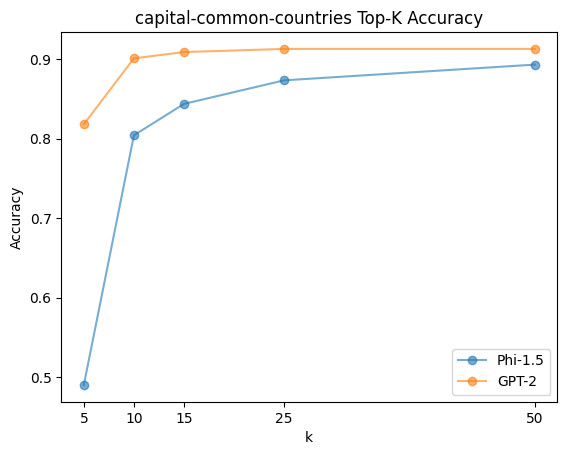

---------------------------
capital-world
Phi-1.5 Rank Score: 0.26
GPT-2 Rank Score: 0.31


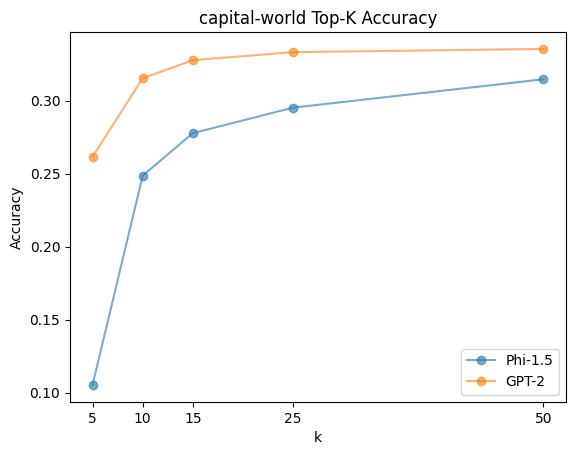

---------------------------
currency
Phi-1.5 Rank Score: 0.23
GPT-2 Rank Score: 0.28


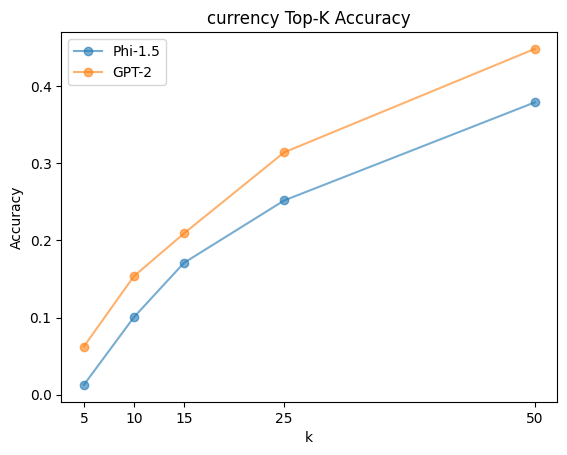

---------------------------
city-in-state
Phi-1.5 Rank Score: 0.38
GPT-2 Rank Score: 0.53


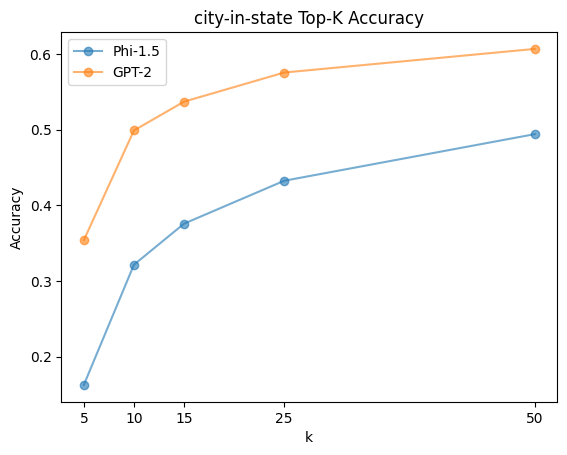

---------------------------
family
Phi-1.5 Rank Score: 0.72
GPT-2 Rank Score: 0.78


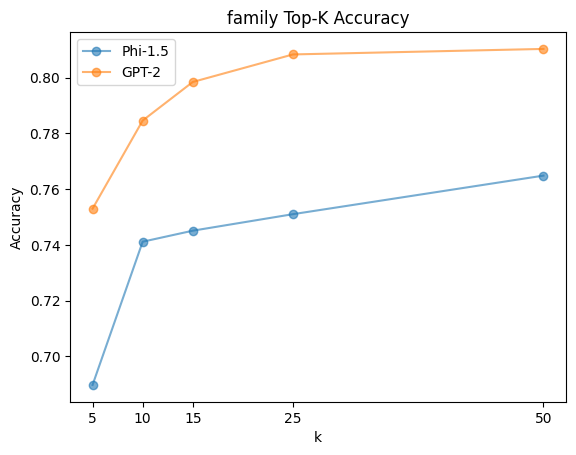

---------------------------
gram1-adjective-to-adverb
Phi-1.5 Rank Score: 0.82
GPT-2 Rank Score: 0.82


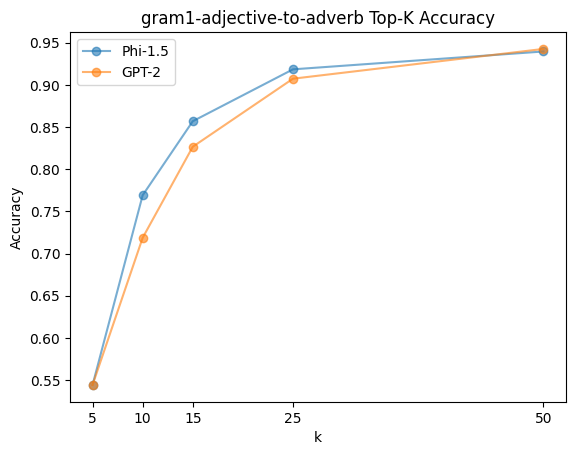

---------------------------
gram2-opposite
Phi-1.5 Rank Score: 0.74
GPT-2 Rank Score: 0.62


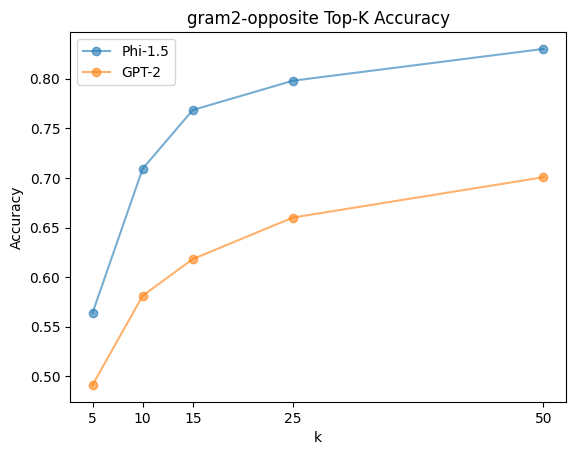

---------------------------
gram3-comparative
Phi-1.5 Rank Score: 0.95
GPT-2 Rank Score: 0.98


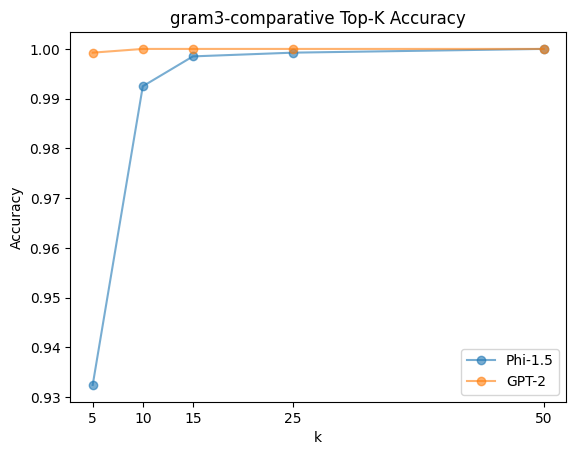

---------------------------
gram4-superlative
Phi-1.5 Rank Score: 0.89
GPT-2 Rank Score: 0.95


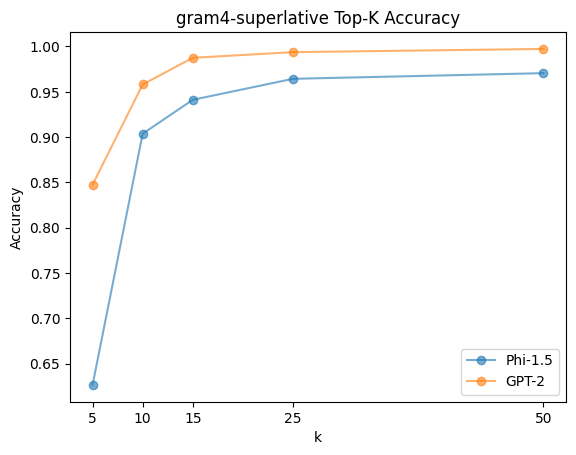

---------------------------
gram5-present-participle
Phi-1.5 Rank Score: 0.96
GPT-2 Rank Score: 0.97


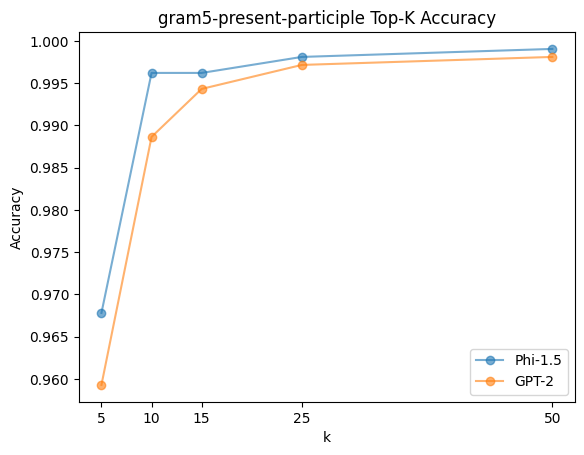

---------------------------
gram6-nationality-adjective
Phi-1.5 Rank Score: 0.89
GPT-2 Rank Score: 0.94


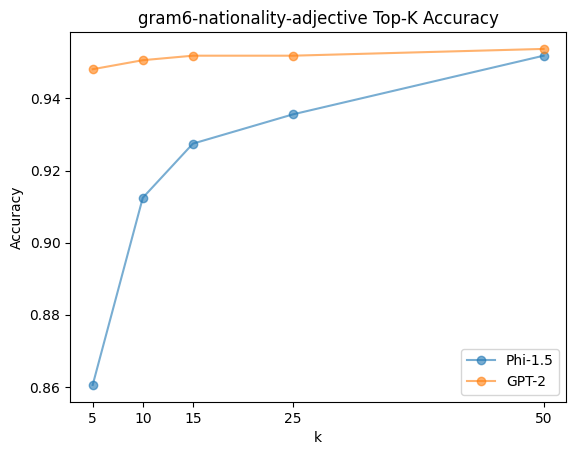

---------------------------
gram7-past-tense
Phi-1.5 Rank Score: 0.92
GPT-2 Rank Score: 0.95


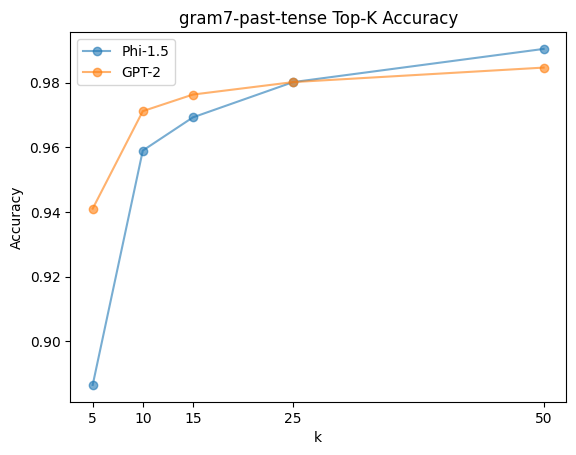

---------------------------
gram8-plural
Phi-1.5 Rank Score: 0.87
GPT-2 Rank Score: 0.91


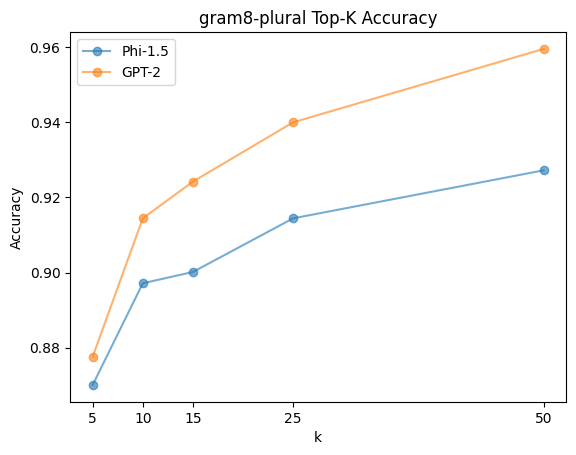

---------------------------
gram9-plural-verbs
Phi-1.5 Rank Score: 0.93
GPT-2 Rank Score: 0.96


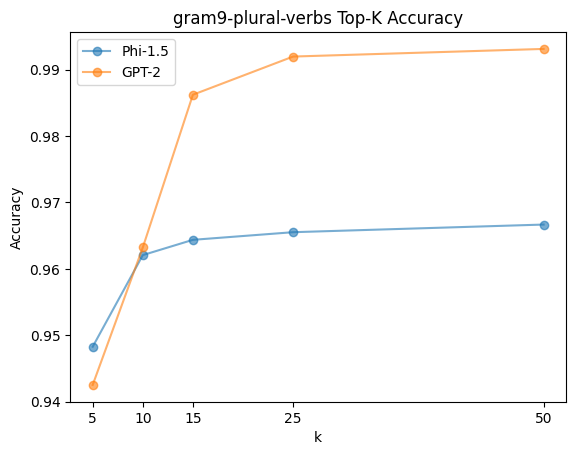

In [71]:
test_k = [5, 10, 15, 25, 50]
for qp, qg, sol in zip(test_questions_phi, test_questions_gpt, test_question_sol):
    name = qp[0]
    print("---------------------------")
    print(name)
    print(f"Phi-1.5 Rank Score: {evaluate_batch(qp[1], sol, out=False, score='rankscore'):.2f}")
    print(f"GPT-2 Rank Score: {evaluate_batch(qg[1], sol, out=False, score='rankscore'):.2f}")
    plt.plot(test_k, [evaluate_batch(qp[1], sol, out=False, score='topk', k=k) for k in test_k], 
             marker='o', alpha=0.6, label='Phi-1.5')
    plt.plot(test_k, [evaluate_batch(qg[1], sol, out=False, score='topk', k=k) for k in test_k], 
             marker='o', alpha=0.6, label='GPT-2')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.xticks(test_k)
    plt.title(name + " Top-K Accuracy")
    plt.legend()
    plt.show()